# Description
Your task is to create a neural network to classify images in the cifar100 dataset.
- You have to write the code from scratch, train the model and test the accuracy on the test set.
- You are not allowed to use pretrained models to do this task.
- You have to submit the .ipynb files with the execution result.

# Grading criteria
- You are graded on the test set accuracy:
  - Test accuracy = 0.50, Grade = 6
  - Test accuracy = 0.55, Grade = 7
  - Test accuracy = 0.60, Grade = 8
  - Test accuracy = 0.65, Grade = 9
  - Test accuracy = 0.70, Grade = 10
- Plagiarism will automatically results in 0 mark.

In [11]:
# DO NOT MODIFY THIS CODE
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from tqdm.auto import tqdm, trange


In [5]:
# You are free to use any other kind of transforms here
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    transforms.RandomErasing(p=0.7, scale=(0.02, 0.2))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

cifar100_train = datasets.CIFAR100('./data',
                                train=True,
                                download=True,
                                transform=train_transform)

cifar100_test = datasets.CIFAR100('./data',
                                train=False,
                                download=True,
                                transform=test_transform)

In [6]:
print(len(cifar100_train))
print(len(cifar100_test))

50000
10000


In [9]:
# DO NOT MODIFY THIS CODE
def evaluate(net: nn.Module,
             data) -> float:
  """
  Evaluates the neural network on the given data.
  @param net: the neural network to evaluate
  @param data: the data to evaluate on
  @return: the accuracy of the neural network on the given data
  """
  data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=100,
                                            shuffle=False)

  correct = 0
  total = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  net.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      pred_target = net(inputs).argmax(dim=1)
      correct += (pred_target == targets).sum().item()
      total += targets.size(0)

  return correct / total

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18(num_classes=100):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def mixup_data(x, y, alpha=2.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
from torch.amp import autocast, GradScaler
import os

def train(train_data, net, **kwargs) -> Tuple[nn.Module, list[float], list[float]]:
    train_losses = []
    train_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device, non_blocking=True)
    net.train()

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=kwargs['batch_size'], shuffle=True,
        num_workers=2, pin_memory=True
    )

    optimizer = opt.SGD(net.parameters(), lr=kwargs['lr'], momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

    scheduler = opt.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kwargs['epochs'])
    scaler = GradScaler('cuda')

    best_train_accuracy = 0.0
    patience = 10
    patience_counter = 0

    model_path = 'best_resnet18.pth'
    checkpoint_path = 'best_resnet18_checkpoint.pth'

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        best_train_accuracy = checkpoint['best_train_accuracy']
        patience_counter = checkpoint['patience_counter']
        print(f"Resumed training from epoch {start_epoch}")
    else:
        print("Starting training from scratch")

    pbar = trange(kwargs['epochs'], desc="Training")
    for epoch in pbar:
        running_loss = 0.0
        correct = 0
        total = 0

        net.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with autocast('cuda'):
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=2.0)
                outputs = net(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets_a.size(0)
            correct += predicted.eq(targets_a).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = evaluate(net, train_data)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        scheduler.step()

        # Lưu mô hình tốt nhất dựa trên train accuracy
        if epoch_accuracy > best_train_accuracy:
            best_train_accuracy = epoch_accuracy
            patience_counter = 0
            torch.save(net.state_dict(), model_path)
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'best_train_accuracy': best_train_accuracy,
                'patience_counter': patience_counter
            }, checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch + 1) % 5 == 0:
            pbar.set_description(f"Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}")

    return net, train_losses, train_accuracies

In [ ]:
net = ResNet18(num_classes=100)
lr = 0.1
batch_size = 64
epochs = 100

optimizer = opt.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = opt.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

net, train_losses, train_accuracies = train(cifar100_train, net, lr=lr, batch_size=batch_size, epochs=epochs)

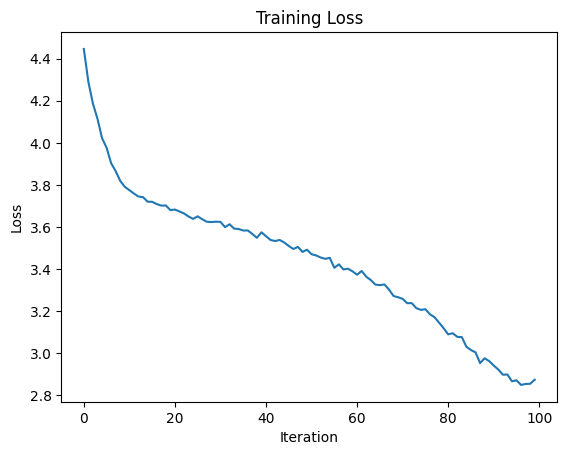

In [ ]:
# DO NOT MODIFY THIS CODE
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

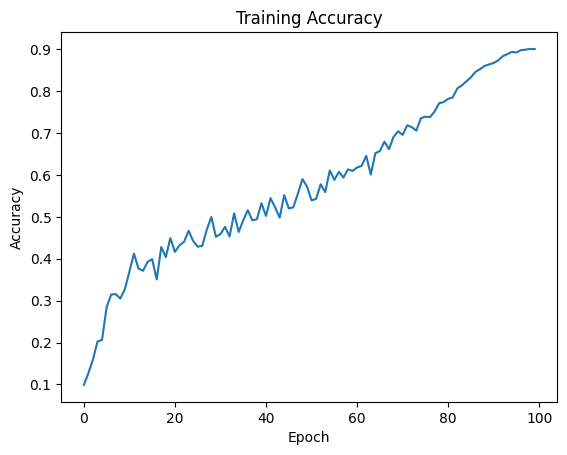

In [ ]:
# DO NOT MODIFY THIS CODE
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# DO NOT MODIFY THIS CODE
test_accuracy = evaluate(net, cifar100_test)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.7692


In [ ]:
net = ResNet18(num_classes=100)
net.load_state_dict(torch.load('best_resnet18.pth'))
test_accuracy = evaluate(net, cifar100_test)
print(f"Test accuracy: {test_accuracy}")